# Esperimento loss function: Binary Cross Entropy (BCE)

In questo notebook proveremo ad eseguire un training completo utilizzando la **Binary Cross Entropy (BCE)** come loss function.

In particolare, dopo aver mostrato come l'implementazione base risulti efficace nel nostro caso per via dello sbilanciamento delle due classi (cellule VS sfondo), procederemo con l'utilizzo della versione weighted (pesata) di questa loss.

## Configurazione esperimento

Per prima cosa, è utile raggruppare tutti gli iperparametri che influenzano l'addestramento della rete neurale in un unico punto d'accesso, così da rendere più semplici eventuali modifiche.

Allo stesso tempo, è buona prassi tener traccia della configurazione di ogni esperimento per ricostruire quali impostazioni hanno portato a ciascun risultato. Nel nostro caso, il progetto è strutturato con due cartelle di logging:

- *log_path*: vengono registrate tutte le metriche di training
- *model_path*: contiene il modello pre-addestrato migliore prodotto da ciascun esperimento

In [1]:
import sys
from fastai.vision.all import *

sys.path.insert(0, str(Path.cwd().parent))

from utils import write_config, load_config

# data and augmentation params
BS = 32
CROP_SIZE = 512
RESIZE = 224
MAX_LIGHT = 0.1
ZOOM_DELTA = 0.1  # min_zoom = 1 - ZOOM_DELTA; max_zoom = 1 + ZOOM_DELTA
MAX_ROTATION_ANGLE = 15.0

# model params
N_IN, N_OUT = 16, 2

# optimizer params
W_CELL, W_BKGD = 1, 1
LOSS_FUNC, LOSS_NAME = CrossEntropyLossFlat(
    axis=1, weight=torch.Tensor([W_BKGD, W_CELL])), 'CrossEntropy'
LR = None
OPT, OPT_NAME = partial(Adam, lr=LR), 'Adam'
MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'dice', 0, 20 # early stopping
FACTOR, PATIENCE_LR = 10/7, 4 # scheduling learning rate


hyperparameter_defaults = dict(
    bs=BS,
    crop_size=CROP_SIZE,
    resize=RESIZE,
    batch_size=BS,
    angle=MAX_ROTATION_ANGLE,
    zoom_delta=ZOOM_DELTA,
    max_light=MAX_LIGHT,
    # model
    n_in=N_IN, n_out=N_OUT,
    # optimizer
    loss_func=LOSS_FUNC, loss_name=LOSS_NAME,
    lr=LR,
    opt=OPT, opt_name=OPT_NAME,
    monit_dict={'score': MONIT_SCORE, 'min_delta': MIN_DELTA, 'patience': PATIENCE_ES},
    lr_monit_dict={'factor': FACTOR, 'patience': PATIENCE_LR},
)

cfg = namedtuple('Config', hyperparameter_defaults.keys())(
    **hyperparameter_defaults)

EXP_NAME = f'BCE_wcell={W_CELL}'
log_path = Path().cwd().parent / 'logs' / EXP_NAME  
log_path.mkdir(exist_ok=True, parents=True)

model_path = f'{log_path.parent.parent}/models/{EXP_NAME}'

# save config
write_config(hyperparameter_defaults, log_path / "cfg.pkl")
# loaded_cfg = load_config(log_path / "cfg.pkl")

##  Dataloader


/home/luca/anaconda3/envs/corso_DLI/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


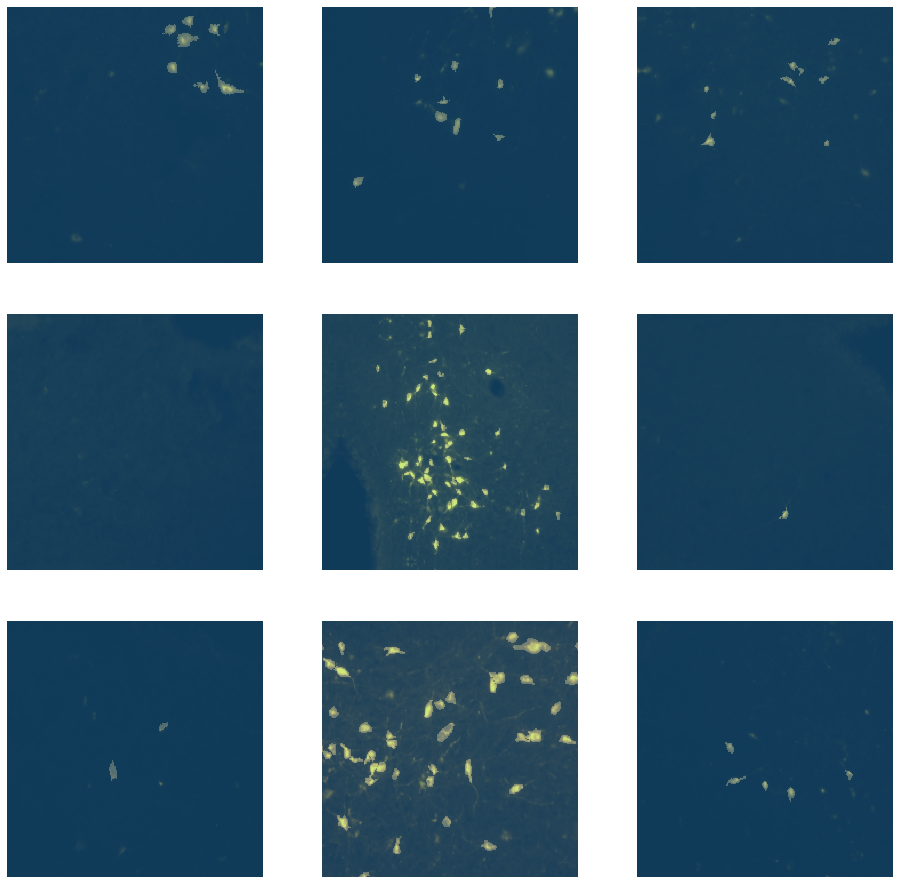

In [2]:
from fastai.vision.all import *

data_path = Path('../fluocells_data/all_images')

# read train/valid/test split dataframe
split_df = pd.read_csv(data_path.parent / 'split_df.csv')
trainval_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='train' or split=='valid'").filename]

def label_func(p):
    return Path(str(p).replace('images', 'masks'))

def is_valid(p):
    return split_df.loc[split_df.filename == p.name, 'split'].values[0] == 'valid'

# augmentation
tfms = [
    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
    RandomCrop(CROP_SIZE),
    *aug_transforms(
        size=RESIZE, # resize
        max_lighting=MAX_LIGHT, p_lighting=0.5, # variazione luminosità
        min_zoom=1-ZOOM_DELTA, max_zoom=1+ZOOM_DELTA, # zoom
        max_warp=0, # distorsione
        max_rotate=MAX_ROTATION_ANGLE # rotazione
    )
]


# splitter
splitter = FuncSplitter(lambda p: is_valid(p))

# dataloader
dls = SegmentationDataLoaders.from_label_func(
    data_path, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    batch_tfms=tfms,
    device='cuda'
)

dls.show_batch(max_n=9, figsize=(16,16))

## Learner

In [3]:
from blocks import cResUnet

model = cResUnet(cfg.n_in, cfg.n_out)

CBS = [
#     ReduceLROnPlateau(monitor=MONIT_SCORE,
#                       patience=PATIENCE_LR, factor=FACTOR),
#     EarlyStoppingCallback(monitor=MONIT_SCORE,
#                           min_delta=MIN_DELTA, patience=PATIENCE_ES),
#     SaveModelCallback(monitor=MONIT_SCORE, min_delta=MIN_DELTA, fname='model',
#                       every_epoch=False, at_end=False, with_opt=False, reset_on_fit=False),
    CSVLogger()
]


learn = Learner(dls, model=model, loss_func=cfg.loss_func,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                cbs=CBS,
                path=log_path , 
                model_dir=model_path,
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/PycharmProjects/c-resunet-DLI/logs/BCE_wcell=1
Model save path: /home/luca/PycharmProjects/c-resunet-DLI/models/BCE_wcell=1


cResUnet (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 1 x 224 x 224  
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     32 x 16 x 224 x 224 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     32 x 16 x 112 x 112 
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                  

## Training

Di seguito procederemo con l'addestramento del modello.

### BCE (standard) 

SuggestedLRs(valley=0.0014454397605732083)

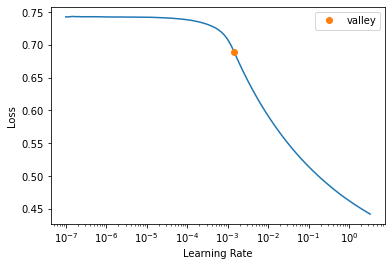

In [11]:
res = learn.lr_find()
res

In [12]:
cfg._replace(lr=res.valley)
cfg._replace(opt=partial(Adam, lr=cfg.lr))
write_config(hyperparameter_defaults, log_path / "cfg.pkl")

learn.fit(50, lr=cfg.lr)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.649509,0.708281,0.013534,0.006813,0.922421,00:12
1,0.500976,0.395708,0.005103,0.002558,0.027728,00:14
2,0.433005,0.372131,0.008975,0.004508,0.024475,00:18
3,0.399276,0.341561,0.003702,0.001855,0.005400,00:12
4,0.379294,0.326645,0.000000,0.000000,0.000000,00:13
5,0.366107,0.320082,0.000000,0.000000,0.000000,00:15
6,0.356830,0.319975,0.000000,0.000000,0.000000,00:16
7,0.349966,0.319942,0.000000,0.000000,0.000000,00:16
8,0.344777,0.319843,0.000000,0.000000,0.000000,00:18
9,0.340714,0.319712,0.000000,0.000000,0.000000,00:16


/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


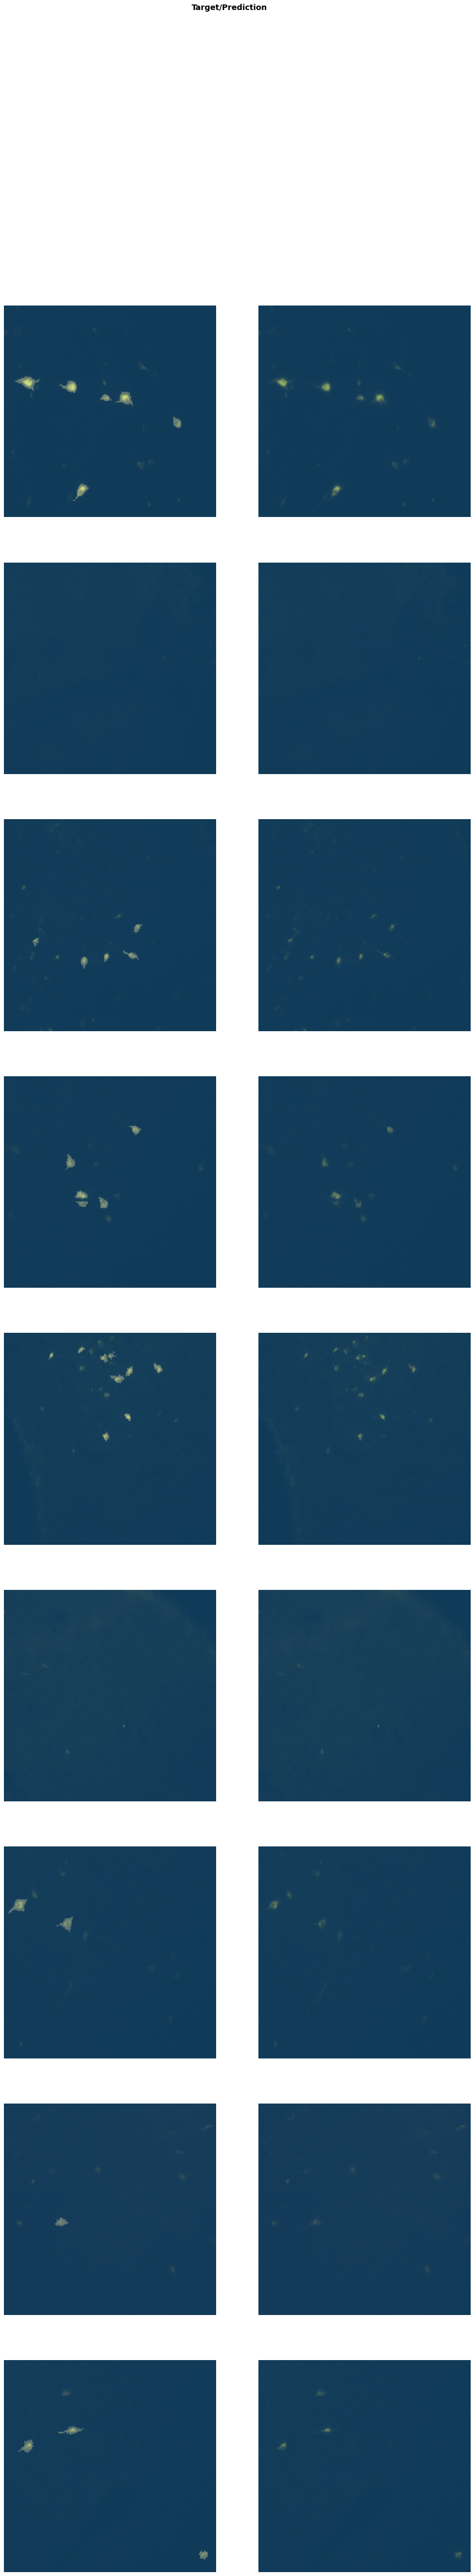

In [13]:
learn.show_results(figsize=(15, 75))

<div class="alert alert-block alert-info">
    
Come visibile dalle metriche di training e dalle immagini sopra, il modello finisce per attribuire sempre la classe "sfondo" a ciascun pixel di input.  
    
Questo è dovuto al grande sbilanciamento tra le due classi (cellule/sfondo) che rende poco importanti gli errori commessi sulla classe più rara (cellule), rendendo la soluzione banale di predire sempre "sfondo" convenienti al fine di minimizzare la loss.
</div>

### BCE weighted

Visto il problema dello sbilanciamento, un possibile rimedio è quello di dare un peso diverso agli errori su ciascuna classe.

In questo modo, il modello sarà penalizzare maggiormente sulla classe più rara (cellule) e questo dovrebbe portarlo a commettere meno errori di questo tipo.

<div class="alert alert-block alert-warning">
    
**Nota:** allo stesso modo, dare un peso eccessivo alla classe più rara potrebbe ribaltare la situazione e comportare il problema inverso. Per questa ragione, bisogna stare molto attenti nella scelta dei pesi per ciascuna classe.

</div>

In [4]:
# optimizer params
W_CELL, W_BKGD = 100, 1
LOSS_FUNC = CrossEntropyLossFlat(
    axis=1, weight=torch.Tensor([W_BKGD, W_CELL]))

cfg._replace(loss_func=LOSS_FUNC)
EXP_NAME = f'BCE_wcell={W_CELL}'
log_path = Path().cwd().parent / 'logs' / EXP_NAME  
log_path.mkdir(exist_ok=True, parents=True)
write_config(hyperparameter_defaults, log_path / "cfg.pkl")

learn = Learner(dls, model=model, loss_func=cfg.loss_func,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                cbs=CBS,
                path=log_path , 
                model_dir=f'{log_path.parent.parent}/models/{EXP_NAME}',
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/PycharmProjects/c-resunet-DLI/logs/BCE_wcell=100
Model save path: /home/luca/PycharmProjects/c-resunet-DLI/models/BCE_wcell=100


cResUnet (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 1 x 224 x 224  
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     32 x 16 x 224 x 224 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     32 x 16 x 112 x 112 
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                  

SuggestedLRs(valley=0.0005754399462603033)

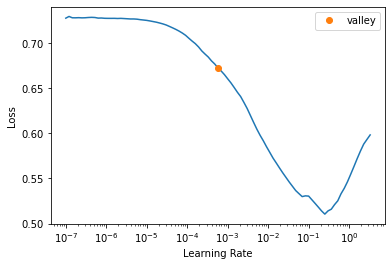

In [12]:
res = learn.lr_find()
res

#### .fit()

Una volta fissato il learning rate iniziale, cominciamo l'addestramento utilizzando il metodo `.fit` dell'oggetto `Learner` che abbiamo definito.

Oltre che il valore della loss nei dati di training e validation, terremo monitorate anche altre metriche che forniscono una misurazione complementare delle performance del modello. In particolare:

 - dice coefficient: misura sovrapposizione tra maschere predette e quelle annotate manualmente
 - foreground accuracy: accuratezza sui pixel in primo piano (no sfondo), i.e. cellule

In [13]:
cfg._replace(lr=res.valley)
cfg._replace(opt=partial(Adam, lr=cfg.lr))
write_config(hyperparameter_defaults, log_path / "cfg.pkl")

learn.fit(50, lr=cfg.lr)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.583395,0.685699,0.000000,0.000000,0.000000,00:12
1,0.520358,0.768075,0.015983,0.008056,0.992742,00:17
2,0.461053,0.864156,0.015718,0.007921,0.999312,00:23
3,0.426533,0.870731,0.015597,0.007860,1.000000,00:11
4,0.404916,0.870548,0.015603,0.007863,1.000000,00:18
5,0.390369,0.868481,0.015649,0.007886,0.999455,00:13
6,0.379682,0.857310,0.015939,0.008034,0.994974,00:18
7,0.371341,0.848849,0.016168,0.008150,0.990944,00:17
8,0.364953,0.844002,0.016310,0.008222,0.986871,00:20
9,0.359808,0.840837,0.016424,0.008280,0.984383,00:18


Come testimoniato dalle metriche, questo primo ciclo è abbastanza instabile. 

Inizialmente, il modello sembra focalizzarsi sulle predizione corretta per i pixel della classe delle cellule (**foreground_accuracy~1**). 

Successivamente, l'aggiornamento dei parametri sembra rimanere bloccato ad una configurazione opposta che si focalizza invece sui pixel di fondo.

A partire dall'**epoca 35**, infine, l'addestramento sembra indirizzarsi verso una zona della loss dove il modello comincia effettivamente ad imparare il task in esame (**dice in crescita**).

Il training termina con un dice coefficient di 0.45 e una foreground accuracy attorno al 31%. In entrambi i casi questi risultati non testimoniano una performance molto accurata, tuttavia il trend di crescita lascia intendere che ci sia ancora margine di miglioramento.

Un altro modo per ispezionare i risultati è quello di guardare le previsioni, in modo da ispezionare forze e debolezze del modello costruito fin qui.

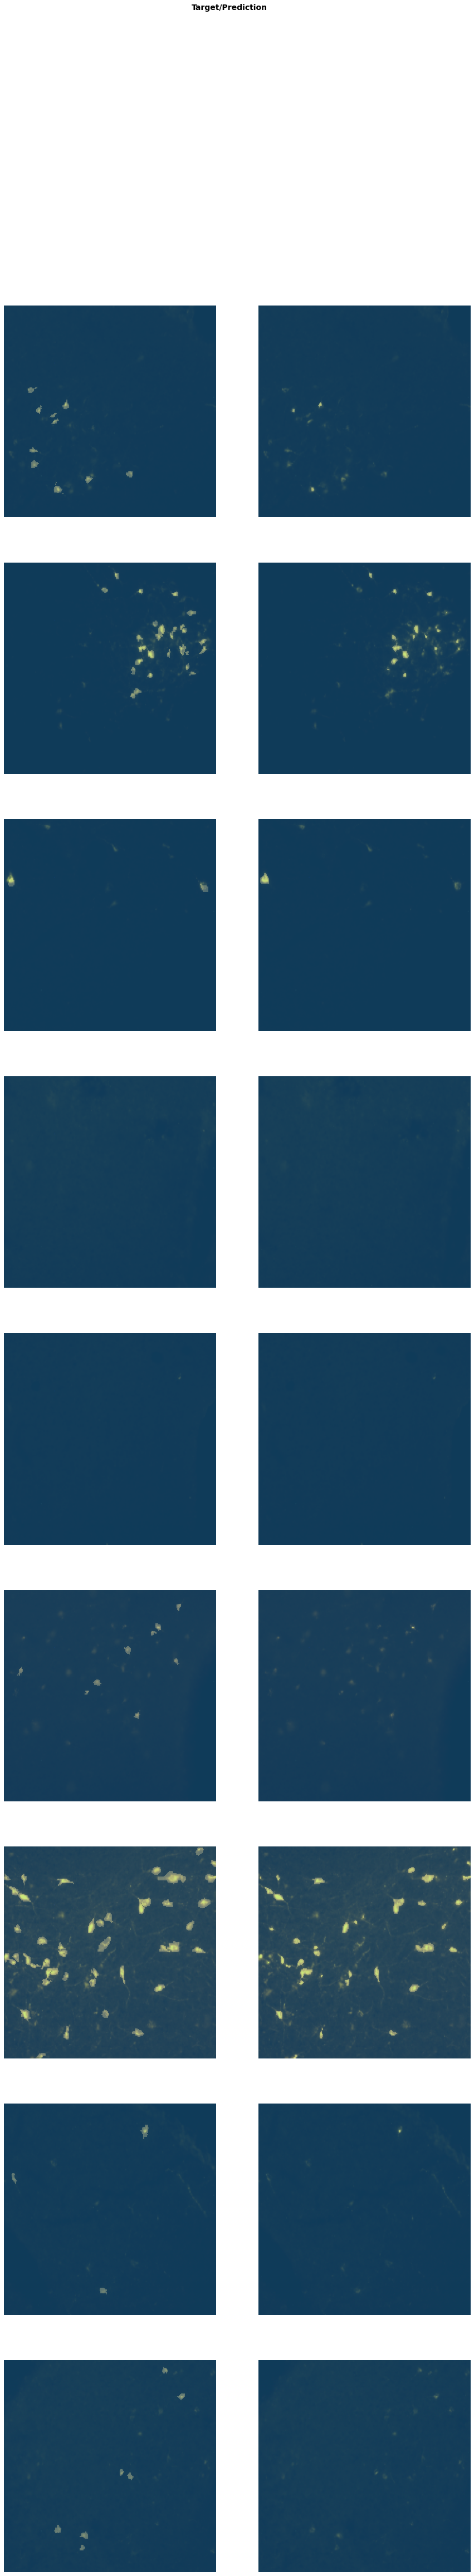

In [14]:
learn.show_results(figsize=(15, 75))

<div class="alert alert-block alert-info">
    
In questo caso notiamo che il modello tende ad essere molto cauto nelle previsioni delle cellule, finendo per mancarle completamente (maschere vuote) oppure tralasciando i pixel sui bordi.
    
</div>

#### Fit_one_cycle

Una volta trovata una buona base, possiamo procedere con più epoche per permettere una convergenza completa.

Tipicamente queste fasi richiedono più accorgimenti tecnici per assicurarsi sia di non uscire dall'intorno del minimo in cui ci si trova, sia di continuare a convergenza non troppo lentamente.

A questo fine utilizziamo una strategia di training lievemente differente implementata tramite il metodo `fit_one_cycle`.

SuggestedLRs(valley=0.00013182566908653826)

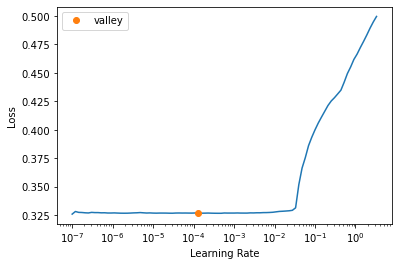

In [15]:
res = learn.lr_find()
res

<div class="alert alert-block alert-info">
    
In questo caso aggiungeremo la callback `SaveModelCallback` per salvare il modello ad ogni miglioramento del *dice coefficient*.
</div>


In [18]:
MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'dice', 0.005, 20
cfg._replace(monit_dict={'score': MONIT_SCORE, 'min_delta': MIN_DELTA, 'patience': PATIENCE_ES})

CBS = [
    SaveModelCallback(monitor=MONIT_SCORE, min_delta=MIN_DELTA, fname='model',
                      every_epoch=False, at_end=False, with_opt=True, reset_on_fit=False),
    CSVLogger(append=True)
]

learn.fit_one_cycle(n_epoch=30, lr_max=cfg.lr, cbs=CBS)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.326411,0.594812,0.468926,0.306273,0.329216,00:10
1,0.326831,0.593750,0.472096,0.308983,0.333333,00:09
2,0.326586,0.605421,0.445760,0.286802,0.305254,00:10
3,0.326607,0.622725,0.403794,0.252971,0.264679,00:10
4,0.326608,0.623987,0.401939,0.251517,0.263969,00:10
5,0.326728,0.627266,0.394090,0.245400,0.256049,00:10
6,0.326766,0.629976,0.384589,0.238075,0.246395,00:12
7,0.326943,0.566002,0.530022,0.360564,0.388739,00:11
8,0.327192,0.479900,0.656389,0.488526,0.596841,00:10
9,0.327279,0.492673,0.638310,0.468763,0.565476,00:12


/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice value: 0.46892595346860727.
Better model found at epoch 7 with dice value: 0.5300216860937924.
Better model found at epoch 8 with dice value: 0.6563892305589722.
Better model found at epoch 18 with dice value: 0.661473121054978.
Better model found at epoch 21 with dice value: 0.671684353232668.


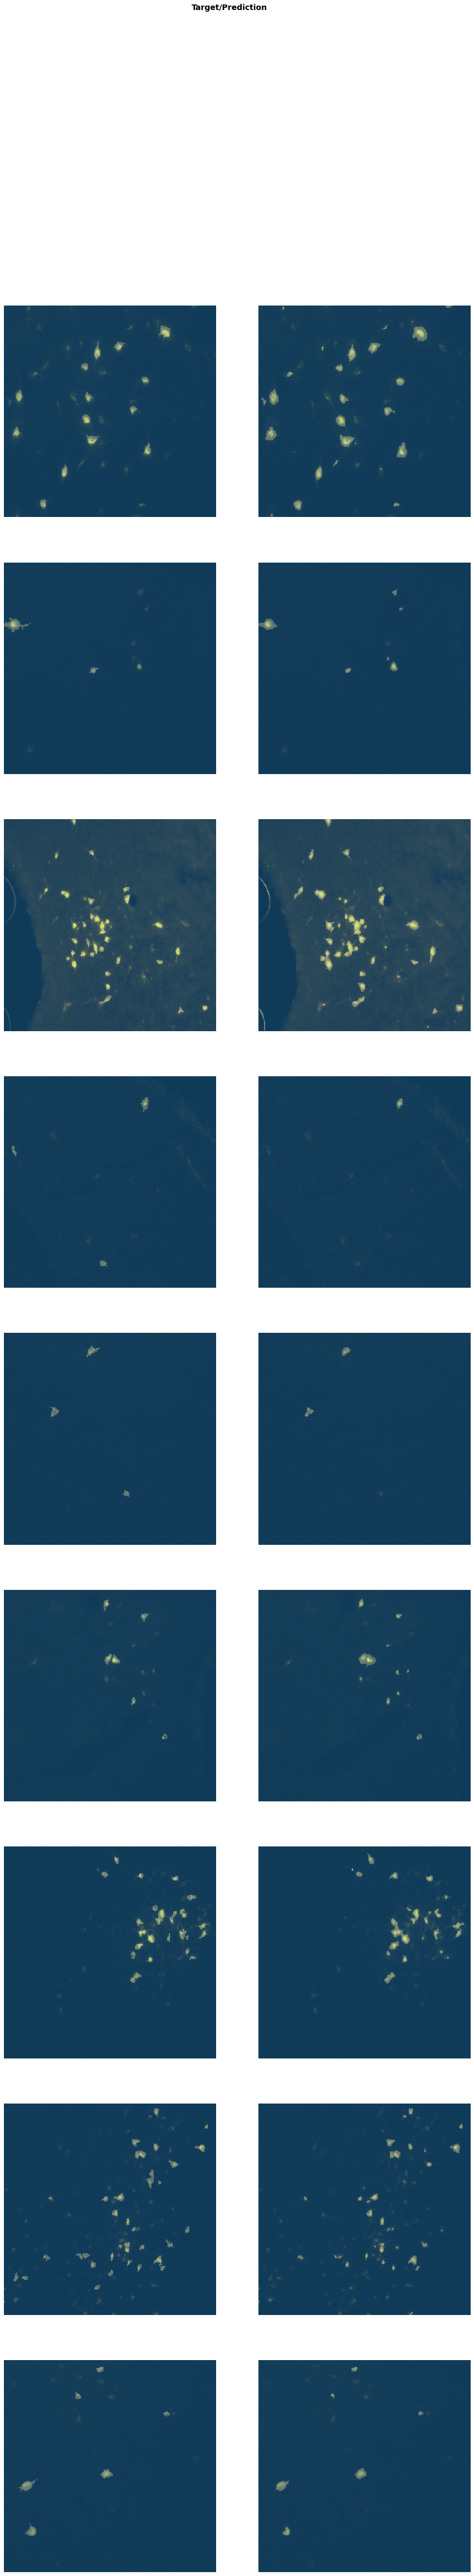

In [19]:
learn.show_results(figsize=(15, 75))

In [20]:
learn.validate()

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(#4) [0.43191269040107727,0.671684353232668,0.5056662208770325,0.7142199277877808]

Dopo le 30 epoche aggiuntive, il modello raggiunge un **dice score attorno al 67%**, con un'**accuratezza del 71%** per i pixel delle cellule.

Guardando poi le maschere predette, notiamo come 

- gli oggetti riconosciuti ricalcano grossomodo bene gli oggetti realmente presenti
- qualche incertezza è presente negli oggetti più piccoli, con una tendenza a overprediction
- le previsioni talvolta includono bordi larghi e filamenti
- oggetti vicini vengono spesso accorpati insieme


<div class="alert alert-block alert-warning">

L'andamento delle metriche nelle epoche finali sembrano suggerire ci sia ancora un margine di miglioramento.    
</div>